In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import the data for games and bets, ready for Feature Engineering

In [6]:
games = pd.read_csv('../Data/CSV_files/games_bets_ready4FE')

if 'Unnamed: 0' in games.columns :
    del games['Unnamed: 0']

games.GameDate =  pd.to_datetime(games.GameDate)

print games.shape
games.head(1)

(5989, 94)


,Season,GameDate,GameTime,HostName,HostScore,GuestName,GuestScore,host_shortname,GameId,gq1,...,h3PAR,hFTr,hDRB%,hTRB%,hAST%,hSTL%,hBLK%,hDRtg,total_line,game_line
0,2013,2012-10-30,7:00 pm,Cleveland Cavaliers,94,Washington Wizards,84,CLE,201210300CLE,24,...,0.253,0.278,66.7,58.1,61.1,8.0,8.6,95.5,191.0,6.0


# Find : 
- Statistical average of home and away team to use for heads up matches 
- Game Ranker. By Game in Season, By home/away in Season, By heads up in Season/All
- If last game had an over time quarter and how many (phisical ability, minutes played)
- Recovery time before each game
- Who was Winner/loser 
- How many wins and loses as host or guest for host and guest
- Games behind
- Streak for home/away
- Streak for playing as home/away
#### Future Work : 
- Last 10 games win and loses
- Time zone change or milage traveled
- Win/Lose By conferance or adding some features to show the game zone
- how many games in last 5 day
- Table 3 Rest days before upcoming game(p 64)
- Scrape players Statistics, remove the players that has rest/injured/banned. aggregate on minutes played for other players
## Aggregated Features: 
- Last 10(n) games As home/away
- Last 3(n) Heads up matches
#### Future Work
- Last 10(n) matches performance

In [7]:
#games['score_diff'] = games.hq1 + games.hq2 + games.hq3 + games.hq4 - games.gq1 - games.gq2 - games.gq3 - games.gq4 
games['ORtg'] = (games['hORtg'] + games['gORtg'])/2.
games['STL%'] = (games['hSTL%'] + games['gSTL%'])/2.
games['TOV%'] = (games['hTOV%'] + games['gTOV%'])/2.
games['ORB%'] = (games['hORB%'] + games['gORB%'])/2.
games['DRB%'] = (games['hDRB%'] + games['gDRB%'])/2.
games['TRB%'] = (games['hTRB%'] + games['gTRB%'])/2.
games['BLK%'] = (games['hBLK%'] + games['gBLK%'])/2.
games['PF'] = (games['hPF'] + games['gPF'])/2.
games['Pace'] = (games['hPace'] + games['gPace'])/2.
games['FGA'] = (games['hFGA'] + games['gFGA'])/2.
games['DRtg'] = (games['hDRtg'] + games['gDRtg'])/2.
games['q1'] = (games['hq1'] + games['gq1'])/2.
games['q2'] = (games['hq2'] + games['gq2'])/2.
games['q3'] = (games['hq3'] + games['gq3'])/2.
games['q4'] = (games['hq4'] + games['gq4'])/2.

In [8]:
def gameranker (row) :

    row['Host_HostRank'] = 1 + len(games[(games.Season == row['Season']) & (games.GameDate < row['GameDate']) & (games.HostName == row['HostName'])])
    row['Host_GameRank'] = 1 + len(games[(games.Season == row['Season']) & (games.GameDate < row['GameDate']) & ((games.HostName == row['HostName']) | (games.GuestName == row['HostName']))])

    row['Guest_GuestRank'] = 1+len(games[(games.Season == row['Season']) & (games.GameDate < row['GameDate']) & (games.GuestName == row['GuestName'])])
    row['Guest_GameRank'] = 1 +len(games[(games.Season == row['Season']) & (games.GameDate < row['GameDate']) & ((games.HostName == row['GuestName']) | (games.GuestName == row['GuestName']))])

    row['Headsup_GameRank_Season'] = 1 + len(games[(games.Season == row['Season']) & (games.GameDate < row['GameDate']) & ((games.HostName == row['HostName']) | (games.GuestName == row['HostName'])) & ((games.HostName == row['GuestName']) | (games.GuestName == row['GuestName']))])
    row['Headsup_GameRank_All'] = 1 + len(games[(games.GameDate < row['GameDate']) & ((games.HostName == row['HostName']) | (games.GuestName == row['HostName'])) & ((games.HostName == row['GuestName']) | (games.GuestName == row['GuestName']))])

    return row

games = games.apply(gameranker,axis=1)

In [9]:
def over_time_counter(row) :
    counter = 0
    if row['hot1'] + row['got1'] > 0 : 
        counter += 1
    if row['hot2'] + row['got2'] > 0 : 
        counter += 1        
    if row['hot3'] + row['got3'] > 0 : 
        counter += 1
    if row['hot4'] + row['got4'] > 0 : 
        counter += 1
    row['ot_counter'] = counter
    return row

games = games.apply(over_time_counter,axis=1)

In [10]:
def if_last_game_had_overtime(row) :
    mask1_host = games['GameDate'] < row['GameDate']
    mask2_host = (games['Season'] == row['Season'])
    mask3_host = ((games['HostName'] == row['HostName']) & (games['Host_GameRank'] == row['Host_GameRank'] -1))
    mask4_host = ((games['GuestName'] == row['HostName']) & (games['Guest_GameRank'] == row['Host_GameRank'] -1))
    temp = games['ot_counter'][mask1_host][mask2_host][mask3_host | mask4_host]
    if len(temp) == 0 :
        row['host_lastgame_overtime'] = 0
    else :
        row['host_lastgame_overtime'] = temp.values[0]

    mask1_guest = games['GameDate'] < row['GameDate']
    mask2_guest = (games['Season'] == row['Season'])
    mask3_guest = ((games['GuestName'] == row['GuestName']) & (games['Guest_GameRank'] == row['Guest_GameRank'] -1))
    mask4_guest = ((games['HostName'] == row['GuestName']) & (games['Host_GameRank'] == row['Guest_GameRank'] -1))
    temp = games['ot_counter'][mask1_guest][mask2_guest][mask3_guest | mask4_guest]
    if len(temp) == 0 :
        row['guest_lastgame_overtime'] = 0
    else :
        row['guest_lastgame_overtime'] = temp.values[0]

    return row

games = games.apply(if_last_game_had_overtime,axis=1)

In [11]:
def rehab_time_host(row) :
    mask = (((games.HostName == row['HostName']) & (games.Host_GameRank == row['Host_GameRank'] -1)) | ((games.GuestName == row['HostName']) & (games.Guest_GameRank == row['Host_GameRank'] -1))) & (games.Season==row['Season'])
    lastgame_date = games[['GameDate']][mask].max()
    lastgame_date = lastgame_date.values[0]
    thisgame_date = row['GameDate']
    
    if pd.isnull(lastgame_date) :
        row['Host_LastGameDiff'] = -1
    else :
        row['Host_LastGameDiff'] = (thisgame_date - lastgame_date) / np.timedelta64(1,'D')
    return row                                                                                

games = games.apply(rehab_time_host, axis =1 )

def rehab_time_guest(row) :
    mask = (((games.GuestName == row['GuestName']) & (games.Guest_GameRank == row['Guest_GameRank'] -1)) | ((games.HostName == row['GuestName']) & (games.Host_GameRank == row['Guest_GameRank'] -1))) & (games.Season==row['Season'])
    lastgame_date = games[['GameDate']][mask].max()
    lastgame_date = lastgame_date.values[0]
    thisgame_date = row['GameDate']
    
    if pd.isnull(lastgame_date) :
        row['Guest_LastGameDiff'] = -1
    else :
        row['Guest_LastGameDiff'] = (thisgame_date - lastgame_date) / np.timedelta64(1,'D')
    return row                                                                                

games = games.apply(rehab_time_guest, axis =1 )


In [12]:
def winner_looser(row) :
    if row['HostScore'] > row['GuestScore'] :
        row['winner'] = row['HostName']
        row['loser'] = row['GuestName']
    else : 
        row['winner'] = row['GuestName']
        row['loser'] = row['HostName']
    return row    
games = games.apply(winner_looser,axis=1)

In [13]:
def win_lose_counter(row) :
    row['host_win_count']  = len(games[(games.GameDate < row['GameDate']) & (games.Season == row['Season']) & (games.winner == row['HostName'])])
    row['host_lose_count'] = len(games[(games.GameDate < row['GameDate']) & (games.Season == row['Season']) & (games.loser == row['HostName'])])

    row['guest_win_count'] = len(games[(games.GameDate < row['GameDate']) & (games.Season == row['Season']) & (games.winner == row['GuestName'])])
    row['guest_lose_count'] = len(games[(games.GameDate < row['GameDate']) & (games.Season == row['Season']) & (games.loser == row['GuestName'])])
    return row
games = games.apply(win_lose_counter,axis=1)

In [14]:
def games_behind(row) :
    row['game_behind'] = ((row['host_win_count'] - row['guest_win_count']) + (row['guest_lose_count'] - row['host_lose_count']))/2.
    return row
games = games.apply(games_behind,axis=1)

In [15]:
def streak_host(row) :
    templist = []
    tempgames = games[['winner','loser']][(games.Season == row['Season']) & (games.GameDate < row['GameDate']) & ((games.loser == row['HostName']) | (games.winner == row['HostName']))]
    for winner in tempgames[['winner']].values :
        if winner == row['HostName'] :
            templist.append(1)
        else :
            templist.append(-1)
    
    row['host_strike'] = 0
    while len(templist) > 0 :
        item = templist.pop()
        #print item,row['host_strike']
        if item == 1 and row['host_strike'] >= 0 :
            row['host_strike'] += item
        elif item == -1 and row['host_strike'] <= 0 :
            row['host_strike'] += item
        else : 
            break
    return row

games = games.apply(streak_host,axis=1)

def streak_guest(row) :
    templist = []
    tempgames = games[['winner','loser']][(games.Season == row['Season']) & (games.GameDate < row['GameDate']) & ((games.loser == row['GuestName']) | (games.winner == row['GuestName']))]
    for winner in tempgames[['winner']].values :
        if winner == row['GuestName'] :
            templist.append(1)
        else :
            templist.append(-1)
    
    row['guest_strike'] = 0
    while len(templist) > 0 :
        item = templist.pop()
        #print item,row['host_strike']
        if item == 1 and row['guest_strike'] >= 0 :
            row['guest_strike'] += item
        elif item == -1 and row['guest_strike'] <= 0 :
            row['guest_strike'] += item
        else : 
            break
    return row

games = games.apply(streak_guest,axis=1)


In [16]:
def streak_place_host(row) :
    templist = []
    tempgames = games[['HostName','GuestName']][(games.Season == row['Season']) & (games.GameDate <= row['GameDate']) & ((games.HostName == row['HostName']) | (games.GuestName == row['HostName']))]
    for team in tempgames[['HostName']].values :
        if team == row['HostName'] :
            templist.append(1)
        else :
            templist.append(-1)
    
    row['host_place_streak'] = 0
    while len(templist) > 0 :
        item = templist.pop()
        if item == 1 and row['host_place_streak'] >= 0 :
            row['host_place_streak'] += item
        elif item == -1 and row['host_place_streak'] <= 0 :
            row['host_place_streak'] += item
        else : 
            break
    return row

games = games.apply(streak_place_host,axis=1)


def streak_place_guest(row) :
    templist = []
    tempgames = games[['HostName','GuestName']][(games.Season == row['Season']) & (games.GameDate <= row['GameDate']) & ((games.HostName == row['GuestName']) | (games.GuestName == row['GuestName']))]
    for team in tempgames[['GuestName']].values :
        if team == row['GuestName'] :
            templist.append(1)
        else :
            templist.append(-1)
    
    row['guest_place_streak'] = 0
    while len(templist) > 0 :
        item = templist.pop()
        if item == 1 and row['guest_place_streak'] >= 0 :
            row['guest_place_streak'] += item
        elif item == -1 and row['guest_place_streak'] <= 0 :
            row['guest_place_streak'] += item
        else : 
            break
    return row

games = games.apply(streak_place_guest,axis=1)


In [926]:
# def win_lose_last10(row) :
#     mask1 = (games.GameDate < row['GameDate']) & (games.Season == row['Season'])
#     mask2 = 

In [949]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth 6371 in kilometers. Use 3956 for miles.
    return c * r

haversine(40.7505, 73.9934, 38.5803, 121.4996)

### Validate the data so far

In [1280]:
#games[(games.GuestName == 'Sacramento Kings') | (games.HostName == 'Sacramento Kings')][games.Season == 2017][['HostName','GuestName','host_place_streak','guest_place_streak']]

In [1201]:
games.isnull().sum()[games.isnull().sum() > 0 ]

Series([], dtype: int64)

In [31]:
heatmap_df = games[['total_score','gPace','geFG%','gTOV%','gORB%','gFT/FGA','gORtg','hPace','heFG%','hTOV%','hORB%','hFT/FGA','hORtg','Host_HostRank','Host_GameRank',
 'Guest_GuestRank',
 'Guest_GameRank',
 'Headsup_GameRank_Season',
 'Headsup_GameRank_All',
 'ot_counter',
 'host_lastgame_overtime',
 'guest_lastgame_overtime',
 'Host_LastGameDiff',
 'Guest_LastGameDiff',
 'host_win_count',
 'host_lose_count',
 'guest_win_count',
 'guest_lose_count',
 'game_behind',
 'host_strike',
 'guest_strike',
 'host_place_streak',
 'guest_place_streak']]

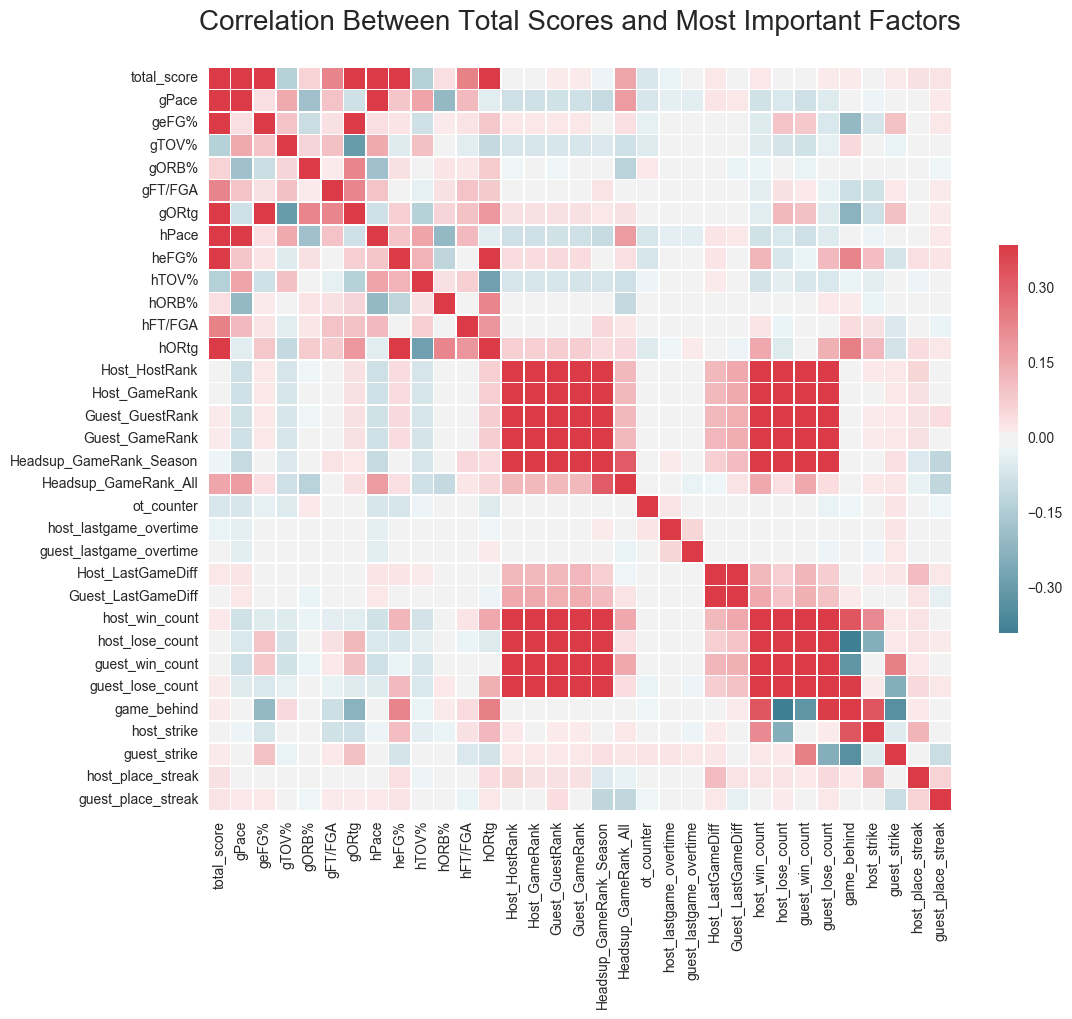

In [35]:
f, ax = plt.subplots(figsize=(12, 10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(heatmap_df.corr(), cmap=cmap, vmax=.3,
            square=True,linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.title('Correlation Between Total Scores and Most Important Factors\n',size=20)
plt.savefig('../Pictures/corr.png', bbox_inches='tight')
plt.show()


In [692]:
#games.to_csv('./Data/CSV_files/Final_Data')

## Try to take the average data of last n matches as host or guest

In [1202]:
games_avg = games[['Season','GameId','GameDate','GameTime','HostName','GuestName',
                   #'HostScore','hq1','hq2','hq3','hq4',
                   #'GuestScore','gq1','gq2','gq3','gq4',
                   'total_score',
                   'total_line','game_line', 
                   'Host_HostRank','Host_GameRank','Guest_GuestRank','Guest_GameRank',
                   'Headsup_GameRank_Season','Headsup_GameRank_All', 'Host_LastGameDiff','Guest_LastGameDiff',
                   'host_win_count','host_lose_count','guest_win_count','guest_lose_count', 
                   'game_behind','host_strike','guest_strike','winner','loser',
                   'host_place_streak','guest_place_streak']]

merge_columns = [x for x in games_avg.columns if x != 'GameId']

print games.shape,games_avg.shape,games_avg[games_avg.Host_HostRank ==1].shape

In [1208]:
def historyData_average_host(row) :
    

    host = games[(games['HostName'] == row['HostName']) & (games['Season'] == row['Season']) & (games['Host_HostRank'] < row['Host_HostRank']) & (games['Host_HostRank'] >= row['Host_HostRank'] - n_lastmatch)]
    final_host = host[['HostName','hq1','hq2','hq3','hq4','hPace','heFG%','hTOV%','hORB%','hFT/FGA','hORtg','hFG', 'hFGA', 'hFG%', 'h3P', 'h3PA', 'h3P%', 'hFT', 'hFTA', 'hFT%', 'hORB', 'hDRB', 'hTRB', 'hAST', 'hSTL', 'hBLK', 'hTOV', 'hPF', 'hPTS', 'hTS%', 'h3PAR', 'hFTr', 'hDRB%', 'hTRB%', 'hAST%', 'hSTL%', 'hBLK%', 'hDRtg']].groupby(['HostName']).mean().reset_index()    
    for col in final_host.columns : 
        if col != 'HostName' :
            row[col+'_avg'+ str(n_lastmatch)] = final_host[col].sum()
        
    return row



def historyData_average_guest(row) :

    guest = games[(games['GuestName'] == row['GuestName']) & (games['Season'] == row['Season']) & (games['Guest_GuestRank'] < row['Guest_GuestRank']) & (games['Guest_GuestRank'] >= row['Guest_GuestRank'] - n_lastmatch)]
    final_guest = guest[['GuestName','gq1','gq2','gq3','gq4','gPace','geFG%','gTOV%','gORB%','gFT/FGA','gORtg','gFG', 'gFGA', 'gFG%', 'g3P', 'g3PA', 'g3P%', 'gFT', 'gFTA', 'gFT%', 'gORB', 'gDRB', 'gTRB', 'gAST', 'gSTL', 'gBLK', 'gTOV', 'gPF', 'gPTS', 'gTS%', 'g3PAR', 'gFTr', 'gDRB%', 'gTRB%', 'gAST%', 'gSTL%', 'gBLK%', 'gDRtg']].groupby(['GuestName']).mean().reset_index()       
    for col in final_guest.columns : 
        if col != 'GuestName' :
            row[col+'_avg'+ str(n_lastmatch)] = final_guest[col].sum()

    return row

n_lastmatch = 10

games_avg_as_host  = games_avg[games_avg.Host_HostRank > n_lastmatch].apply(historyData_average_host, axis=1)
games_avg_as_guest  = games_avg[games_avg.Guest_GuestRank > n_lastmatch].apply(historyData_average_guest, axis=1)

games_avg_as_host = games_avg_as_host[[x for x in games_avg_as_host.columns if x not in merge_columns]]
games_avg_as_guest = games_avg_as_guest[[x for x in games_avg_as_guest.columns if x not in merge_columns]]
print games_avg_as_host.shape,games_avg_as_guest.shape

games_avg_as_host_or_guest = games_avg_as_host.merge(games_avg_as_guest,on='GameId',how='inner')
print games_avg_as_host_or_guest.shape

(4490, 65) (4490, 65)
(4490, 38) (4490, 38)
(5990, 28) (5990, 132)
(4351, 102)


In [1271]:
n_last_headsups = 3
def historyData_last_headsups(row) :
    
    mask1 = (games['GameDate'] < row['GameDate'])
    mask2 = ((games['HostName'] == row['HostName']) & (games['GuestName'] == row['GuestName'])) | ((games['HostName'] == row['GuestName']) & (games['GuestName'] == row['HostName'])) 
    mask3 = games['Headsup_GameRank_All'] >= row['Headsup_GameRank_All'] - n_last_headsups
    columns = ['q1','q2','q3','q4','Pace','PF','FGA','DRtg','ORtg','STL%','TOV%','ORB%','DRB%','TRB%','BLK%']
    tempgames = games[mask1][mask2][mask3][columns]
    
    temp = tempgames.mean()
    for col in columns : 
        if len(tempgames) > 0 : 
            row[col+'_headsup'+ str(n_lastmatch)] = temp[col]
        else : 
            row[col+'_headsup'+ str(n_lastmatch)] = 0
    return row

games_avg_headsup = games_avg[games_avg.Headsup_GameRank_All > 1].apply(historyData_last_headsups,axis=1)
games_avg_headsup = games_avg_headsup[[x for x in games_avg_headsup.columns if x not in merge_columns]]
print games_avg_headsup.shape,games_avg.shape


In [ ]:
games_avg_final = games_avg.merge(games_avg_as_host_or_guest,on='GameId',how='inner').merge(games_avg_headsup,on='GameId',how='inner')
print games.shape,games_avg_as_host_or_guest.shape,games_avg_final.shape

In [1278]:
games_avg_final.to_csv('./Data/CSV_files/games_avg_final02')

In [872]:
n_last_totalmatch = 10

def historyData_average_host_game(row) :
    
    mask1 = games['Season'] == row['Season']
    mask2 = (games['HostName'] == row['HostName']) & (games['Host_GameRank'] < row['Host_GameRank']) & (games['Host_GameRank'] >= row['Host_GameRank'] - n_lastmatch)
    mask3 = (games['GuestName'] == row['HostName']) & (games['Guest_GameRank'] < row['Host_GameRank']) & (games['Guest_GameRank'] >= row['Host_GameRank'] - n_lastmatch)

    host = games[mask2][mask2 | mask3]
    final_host = host[['HostName','hq1','hq2','hq3','hq4','hPace','heFG%','hTOV%','hORB%','hFT/FGA','hORtg','hFG', 'hFGA', 'hFG%', 'h3P', 'h3PA', 'h3P%', 'hFT', 'hFTA', 'hFT%', 'hORB', 'hDRB', 'hTRB', 'hAST', 'hSTL', 'hBLK', 'hTOV', 'hPF', 'hPTS', 'hTS%', 'h3PAR', 'hFTr', 'hDRB%', 'hTRB%', 'hAST%', 'hSTL%', 'hBLK%', 'hDRtg']].groupby(['HostName']).mean().reset_index()    
    for col in final_host.columns : 
        if col != 'HostName' :
            row[col+'_avg_game'+ str(n_lastmatch)] = final_host[col].sum()       
    return row



def historyData_average_guest(row) :

    mask1 = games['Season'] == row['Season']
    mask2 = (games['HostName'] == row['GuestName']) & (games['Host_GameRank'] < row['Guest_GameRank']) & (games['Host_GameRank'] >= row['Guest_GameRank'] - n_lastmatch)
    mask3 = (games['GuestName'] == row['GuestName']) & (games['Guest_GameRank'] < row['Guest_GameRank']) & (games['Guest_GameRank'] >= row['Guest_GameRank'] - n_lastmatch)

    guest = games[(games['GuestName'] == row['GuestName']) & (games['Season'] == row['Season']) & (games['Guest_GuestRank'] < row['Guest_GuestRank']) & (games['Guest_GuestRank'] >= row['Guest_GuestRank'] - n_lastmatch)]
    final_guest = guest[['GuestName','gq1','gq2','gq3','gq4','gPace','geFG%','gTOV%','gORB%','gFT/FGA','gORtg','gFG', 'gFGA', 'gFG%', 'g3P', 'g3PA', 'g3P%', 'gFT', 'gFTA', 'gFT%', 'gORB', 'gDRB', 'gTRB', 'gAST', 'gSTL', 'gBLK', 'gTOV', 'gPF', 'gPTS', 'gTS%', 'g3PAR', 'gFTr', 'gDRB%', 'gTRB%', 'gAST%', 'gSTL%', 'gBLK%', 'gDRtg']].groupby(['GuestName']).mean().reset_index()       
    for col in final_guest.columns : 
        if col != 'GuestName' :
            row[col+'_avg_game'+ str(n_lastmatch)] = final_guest[col].sum()
    return row